### < 이진분류 프로젝트 >
1. 정상/폐렴 데이터셋 사용 : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
2. 데이터셋 로드하기         
   레이블(클래스) 리스트 선언하여 폴더 하위 이미지 읽어 입력 및 출력(X, y) 데이터 생성
3. 데이터 전처리하기      
4. 모델 구성하기         
   CNN 모델 구성하고 Compile 하기
5. 모델 학습하기
6. 모델 학습과정 살펴보기(학습횟수에 따른 accuracy/loss 그래프 그리기)
7. 모델 평가 및 예측하기
8. 모델 예측 결과 출력(이미지+결과)하기 ( pred_label / true_label )
9. 모델 저장하기

# 폐렴이란?

**폐렴은 주로 폐포라고 알려진 작은 공기주머니에 영향을 미치는 폐의 염증성 질환입니다.증상에는 일반적으로 마른 기침, 가슴 통증, 발열 및 호흡곤란 등이 있습니다. 증상의 심각도는 다양합니다. 폐렴은 보통 바이러스나 박테리아에 감염되어 발생하며, 다른 미생물, 특정 약물, 자가면역질환 등으로 발병하는 경우는 적습니다. 위험인자로는 낭포성 섬유증, 만성폐쇄성폐질환(COPD), 천식, 당뇨병, 심부전, 흡연 이력, 뇌졸중 발생, 면역력 약화 등이 있습니다. 폐렴 진단은 증상 발생과 신체검사를 기반으로 이루어 집니다. 흉부 엑스레이, 혈액 검사, 가래 배양 등이 진단을 확인하는 데 도움이 될 수 있습니다. 이 질병은 지역사회, 병원, 의료 관련 등 발병 장소에 따라 분류할 수 있습니다.**


# 폐렴 데이터 세트에 대한 설명

**데이터 세트는 3개의 폴더(train, test, val)로 구성되며 각 이미지 범주(Pneumonia/Normal)에 대한 하위 폴더를 포함합니다. 5,863개의 X-Ray 이미지(JPEG)와 2개의 카테고리(Pneumonia/Normal)가 있습니다. 흉부 X선 영상(전후방)은 소아 환자 소급 집단에서 선택되었습니다. 모든 흉부 X선 영상 촬영은 환자의 일상적인 임상 치료의 일부로 수행되었습니다. 흉부 X선 영상의 분석을 위해, 흉부 X선 사진은 품질 관리를 위해 품질이 낮거나 읽을 수 없는 이미지는 모두 제거하고 선별하였습니다. AI 시스템을 훈련시키기 전에 두 명의 전무 의사가 이미지에 대한 라벨 분류 작업을 진행하였습니다. 오류를 방지하기 위해 세 번째 전문가가 평가 세트도 확인했습니다.**

## 1.라이브러리 가져오기

In [ ]:
import numpy as np    # 선형 대수 지원 라이브러리
import pandas as pd   # 데이터 처리, CSV 파일 I/O(예: pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

## 2.데이터세트 불러오기

In [ ]:
!gdown 1hF1Jyd-qu_DGzhe-1_vhf9xQr82Wti17
# linux 환경에서 압축 풀기
# !unzip -qq "chest_xray.zip"

# Windows 환경에서 압축 풀기
!tar -xf chest_xray.zip

Downloading...
From (original): https://drive.google.com/uc?id=1hF1Jyd-qu_DGzhe-1_vhf9xQr82Wti17
From (redirected): https://drive.google.com/uc?id=1hF1Jyd-qu_DGzhe-1_vhf9xQr82Wti17&confirm=t&uuid=1fdfd2f2-7d5b-4655-9387-9b541a18e878
To: /content/chest_xray.zip
100% 1.23G/1.23G [00:21<00:00, 58.1MB/s]


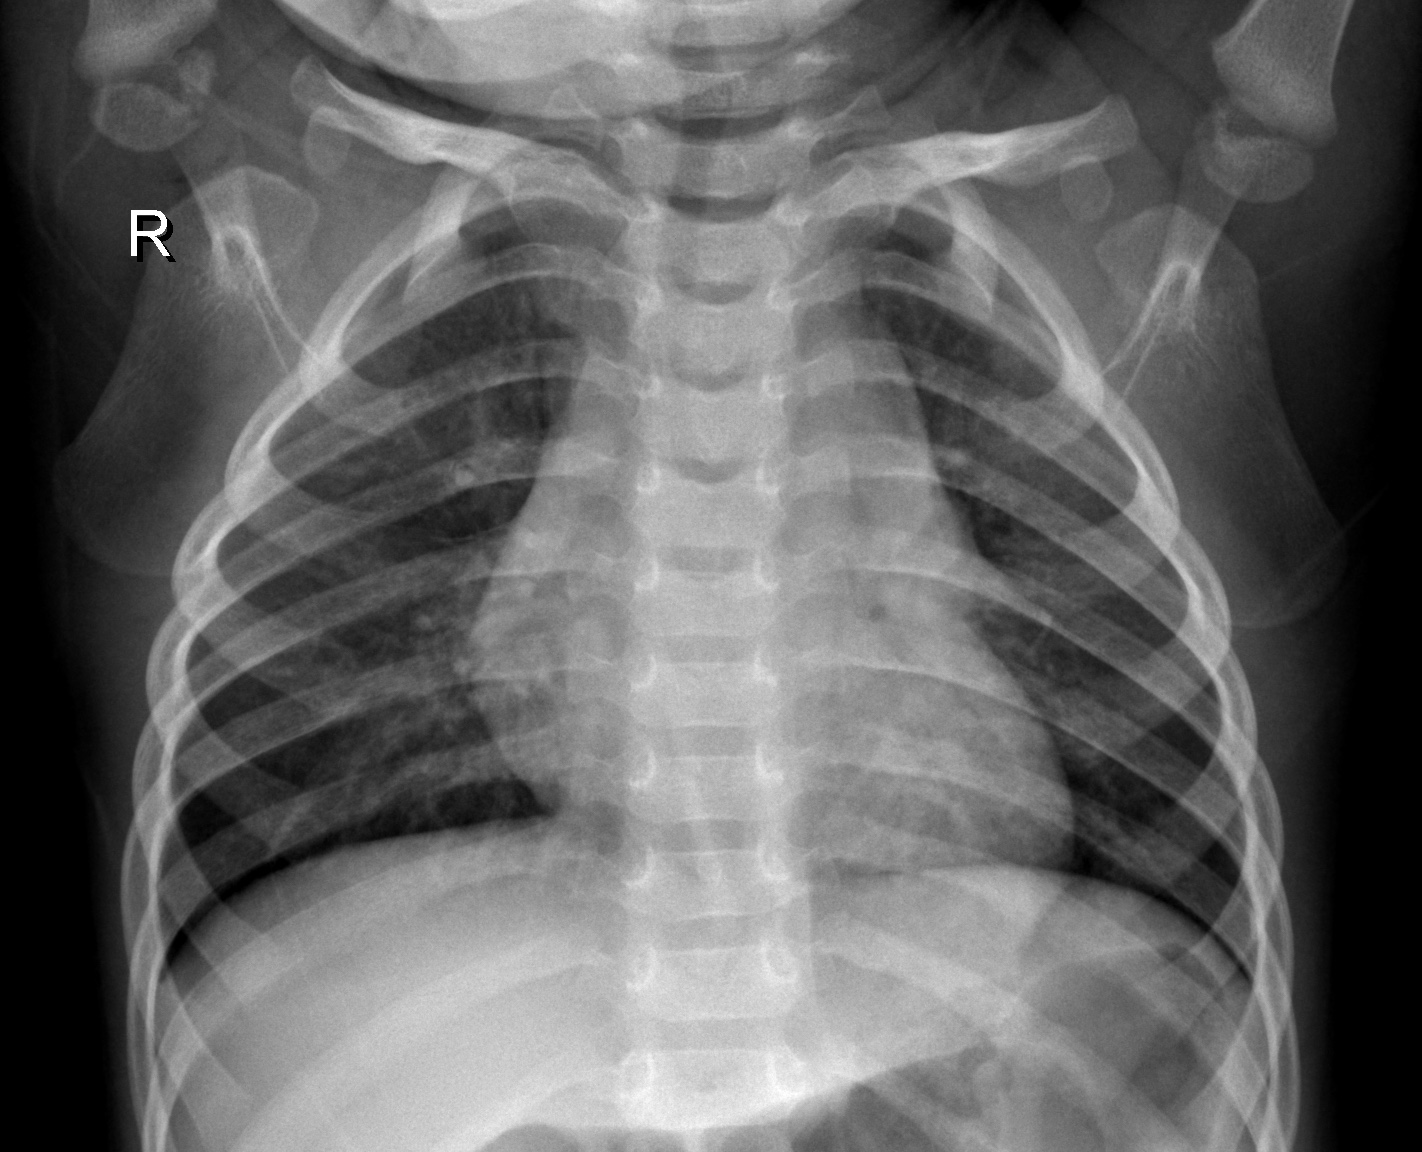

In [ ]:
import tensorflow as tf
tf.keras.preprocessing.image.load_img('./chest_xray/train/NORMAL/IM-0117-0001.jpeg')

In [ ]:
# 조도 차이의 영향을 줄이기 위해 그레이스케일 정규화를 수행합니다. 또한 CNN은 [0..255] 보다 [0..1] 데이터에서 더 빠르게 수렴할 수 있습니다.
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (48, 48))

  return image

In [ ]:
import cv2
import os

X = []
y = []

parent_path = "./chest_xray"
uncle_path = ["train","test","val"]
child_path = ["NORMAL","PNEUMONIA"]

for uncle in uncle_path:
    for child in child_path:
            path = os.path.join(parent_path, uncle, child)
            for filename in os.listdir(path):
                try:
                    img = cv2.imread(os.path.join(path,filename))
                    img_processed = preprocess(img)
                    X.append(img_processed)
                    y.append(child)
                except:
                    print(os.path.join(path,filename))

In [ ]:
# 읽어온 각 데이터를 훈련 데이터와 테스트 데이터로 나누기

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
class_dict = {"NORMAL": 0,"PNEUMONIA": 1}

for i in range(0,len(y_train)):
    y_train[i] =class_dict[y_train[i]]

for i in range(0,len(y_test)):
    y_test[i] =class_dict[y_test[i]]

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4095, 48, 48, 3)
(4095,)
(1755, 48, 48, 3)
(1755,)


## 3.데이터 시각화 및 전처리

## 4.모델 구성하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

num_classes = 1                     # len(train_dataset.class_indices)
num_detectors = 16
width, height = 48, 48                 #  np.array(img).shape[1], np.array(img).shape[0]

model = Sequential()

model.add(keras.layers.Input(shape=(width, height, 3)))

model.add(Conv2D(filters=num_detectors, kernel_size=3,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=num_detectors, kernel_size=3,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=2*num_detectors, kernel_size=3,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=2*num_detectors, kernel_size=3,padding='same', activation='relu'))
model.add(BatchNormalization())    # ... 코드입력
model.add(MaxPooling2D(pool_size=(2, 2)))    # ... 코드입력
model.add(Dropout(0.2))    # ... 코드입력

model.add(Conv2D(filters=2*num_detectors, kernel_size=3,padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=2*num_detectors, kernel_size=3,padding='same', activation='relu'))
model.add(BatchNormalization())    # ... 코드입력
model.add(MaxPooling2D(pool_size=(2, 2)))    # ... 코드입력
model.add(Dropout(0.2))    # ... 코드입력

model.add(Flatten())

model.add(Dense(2*2*num_detectors, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(2*num_detectors, activation='relu'))
model.add(BatchNormalization())    # ... 코드입력    # ... 코드입력
model.add(Dropout(0.2))     # ... 코드입력

model.add(Dense(1, activation='sigmoid'))    # ... 코드입력

## 5.모델 컴파일 하기

In [ ]:
model.compile(optimizer="Adam",
              loss="binary_crossentropy",
              metrics=['accuracy'])  # ... 코드입력

## 6.모델 학습하기

In [ ]:
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs)

Epoch 1/10
128/128 [==============================] - 13s 16ms/step - loss: 0.3830 - accuracy: 0.8501
Epoch 2/10
128/128 [==============================] - 2s 13ms/step - loss: 0.2078 - accuracy: 0.9294
Epoch 3/10
128/128 [==============================] - 1s 10ms/step - loss: 0.1855 - accuracy: 0.9368
Epoch 4/10
128/128 [==============================] - 1s 10ms/step - loss: 0.1682 - accuracy: 0.9411
Epoch 5/10
128/128 [==============================] - 1s 11ms/step - loss: 0.1603 - accuracy: 0.9451
Epoch 6/10
128/128 [==============================] - 3s 22ms/step - loss: 0.1540 - accuracy: 0.9475
Epoch 7/10
128/128 [==============================] - 2s 19ms/step - loss: 0.1310 - accuracy: 0.9504
Epoch 8/10
128/128 [==============================] - 3s 22ms/step - loss: 0.1248 - accuracy: 0.9536
Epoch 9/10
128/128 [==============================] - 2s 18ms/step - loss: 0.1246 - accuracy: 0.9578
Epoch 10/10
128/128 [==============================] - 2s 17ms/step - loss: 0.1170 - accur

## 7.모델 학습과정 살펴보기(학습횟수에 따른 accuracy/loss 그래프 그리기)

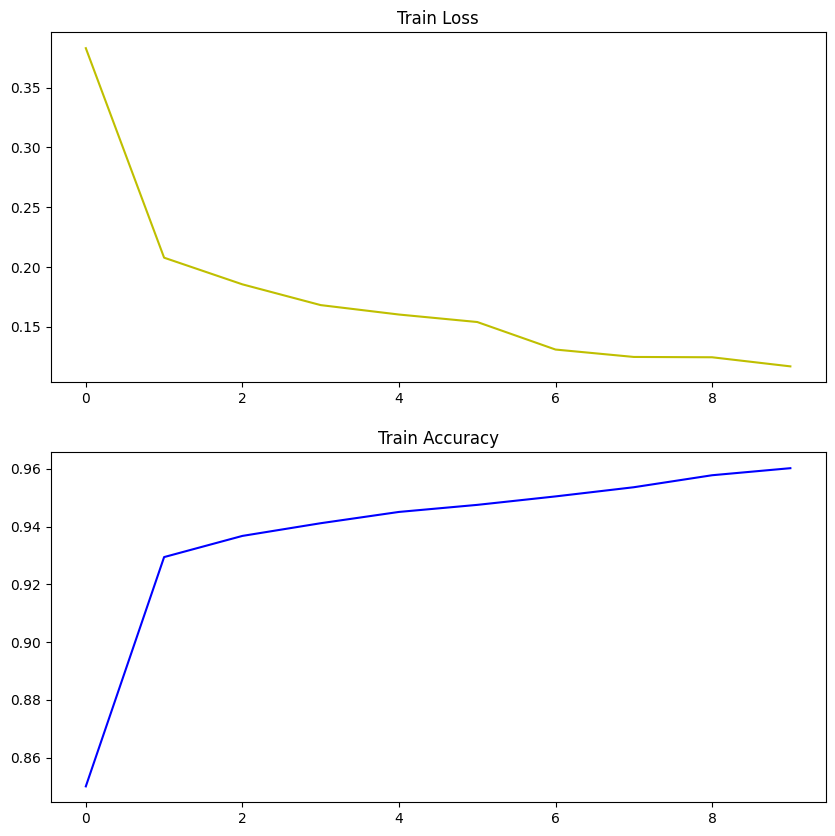

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1,figsize=(10,10))

axes[0].plot(history.history['loss'], 'y', label='train loss')
axes[0].title.set_text("Train Loss")

axes[1].plot(history.history['accuracy'], 'b', label='train accuracy')
axes[1].title.set_text("Train Accuracy")

plt.show()

## 8.모델 평가 및 예측하기

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

55/55 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9607
Loss of the model is -  0.11948604136705399
55/55 [==============================] - 0s 4ms/step - loss: 0.1195 - accuracy: 0.9607
Accuracy of the model is -  96.06837630271912 %


In [ ]:
preds = model.predict(np.array(X_test))   # ... 코드입력
preds

55/55 [==============================] - 1s 10ms/step


array([[7.5493646e-01],
       [3.9685469e-02],
       [9.9709332e-01],
       ...,
       [9.9773812e-01],
       [9.9830127e-01],
       [4.8361826e-04]], dtype=float32)

In [ ]:
pred_bin = []
for pred in preds:
    if pred > 0.5:
        pred_bin.append(1)
    else:
        pred_bin.append(0)
pred_bin = np.array(pred_bin)

In [ ]:
cm = confusion_matrix(y_test,pred_bin)
cm

array([[ 471,   31],
       [  38, 1215]])

<Axes: >

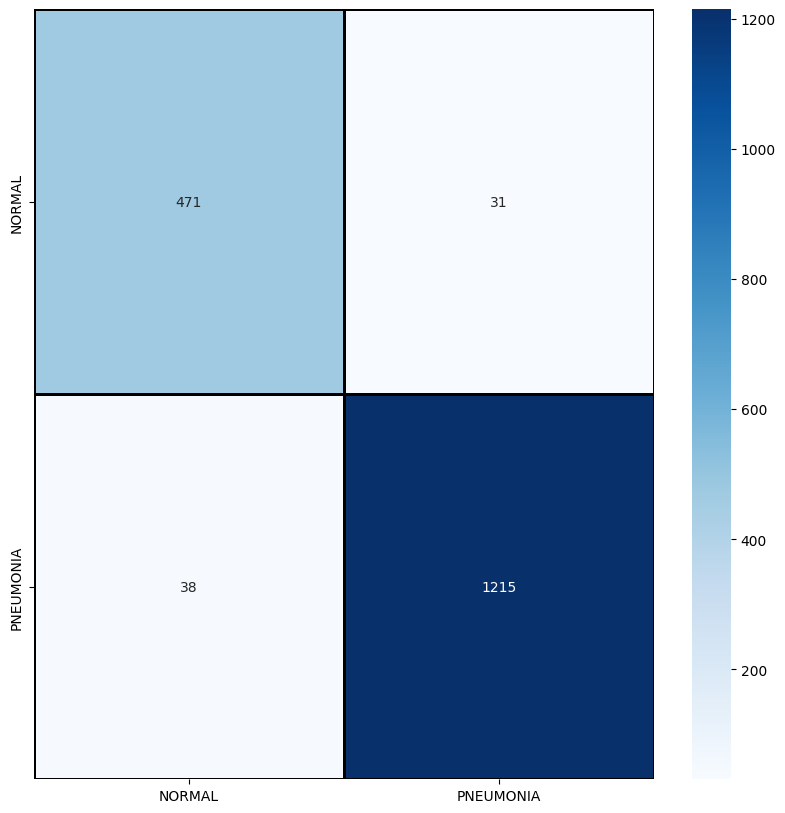

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
print(classification_report(y_test, pred_bin, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.94      0.93       502
   Normal (Class 1)       0.98      0.97      0.97      1253

           accuracy                           0.96      1755
          macro avg       0.95      0.95      0.95      1755
       weighted avg       0.96      0.96      0.96      1755



In [ ]:
import pandas as pd

df_result = pd.DataFrame(columns=['Actual', 'Predicted'])
df_result['Actual'] = y_test
df_result['Predicted'] = pred_bin
df_result

,Actual,Predicted
0,1,1
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
1750,1,1
1751,1,1
1752,1,1
1753,1,1


## 9.모델 예측 결과 출력(이미지+결과)하기 ( pred_label / true_label )

In [ ]:
# 시각화할 이미지 개수
import matplotlib.pyplot as plt
num_images = 5

samples_to_display = np.random.choice(len(X_test), num_images, replace=False)
samples_to_display

array([1498,  319,   61, 1170, 1195])

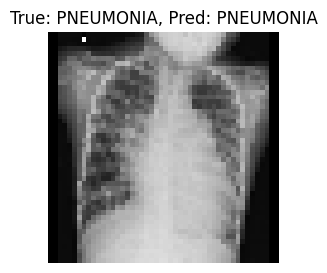

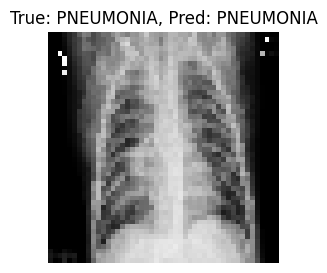

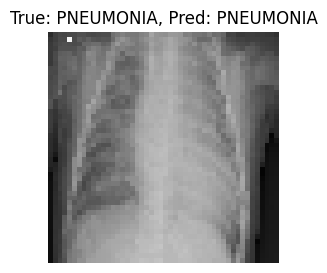

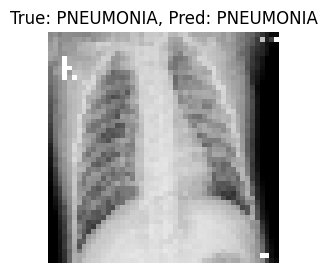

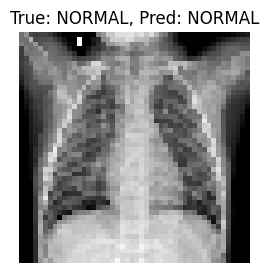

In [ ]:
# 테스트 데이터 중 일부 이미지 시각화
class_dict_r = {0 : "NORMAL",1:"PNEUMONIA"}

for i, idx in enumerate(samples_to_display):
    img = np.array(X_test[idx])  # 이미지와 레이블을 가져옵니다
    true_label = df_result['Actual'].iloc[idx]
    pred_label = df_result['Predicted'].iloc[idx]
    plt.figure(figsize=(5, 3))
    plt.imshow(img)
    plt.title(f"True: {class_dict_r[true_label]}, Pred: {class_dict_r[pred_label]}")
    plt.axis('off')
    plt.show()

## 10.모델 저장하기

In [ ]:
from keras.models import save_model

# 모델 전체를 'model.h5' 파일로 저장
save_model(model, 'x_ray_model.h5')

# 모델의 구조를 JSON 문자열로 반환-모델을 구성하는 각 레이어의 구성과 설정이 포함
with open('x_ray_trained_model.json', 'w') as trained_model_json:
    trained_model_json.write(model.to_json())

# 모델 구조 로드하기
with open('x_ray_trained_model.json', 'r') as trained_model_json:
    trained_model_json = trained_model_json.read()

# 모델 가중치 저장하기
save_model(model, 'weights_x_ray.hdf5')

# Load the trained model & weights
model = tf.keras.models.model_from_json(trained_model_json)
model.load_weights('weights_x_ray.hdf5')